In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = True
# can change this to false after we have run this code for once
# created our dataset with the images - dont want to use extra space/memory

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat"
    DOGS = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog"
    
    LABELS = {CATS:0, DOGS:1}
    
    training_data = []
    catCount = 0
    dogCount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            # iterating over all the images in the directory
            # tqdm - just to tell the progress (where the iterator is)
            for f in tqdm(os.listdir(label)):    
                try:
                    path = os.path.join(label, f)
                    # label - path of directory
                    # f - path of the iamge
                    # label + f
                    
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    # converts img to grayscale
                    # WHY? - color is an added data (which we dont need)
                    # greyscale does not decreases another dimension (its just reduces unrequired data)
                    
                    # important though - do colors matter in recognizing cats & dogs
                    
                    if img is None:
                        continue  # Skip images that can't be loaded
                    
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    # numpy array of img & class labels (used one hot vector)
                    # for a cat: [1, 0]
                    # for a dog: [0, 1]

                    # one hot encoding
                    # np.eye(2)[0] -> o/p: array([1., 0.]) -> for a cat
                    # np.eye(2)[1] -> o/p: array([0., 1.]) -> for a dog
                    
                    if label == self.CATS:
                        self.catCount += 1
                    elif label == self.DOGS:
                        self.dogCount += 1
                
                except Exception as e:
                    # print(str(e))
                    pass
                # why try & except - because some of the images might not be good
                # so if we try to load them in, might get an error
        
        np.random.shuffle(self.training_data)
        
        # separating the images and labels
        images = []
        labels = []
        
        for data in self.training_data:
            images.append(data[0])
            labels.append(data[1])
            
        # converting lists to numpy arrays
        images = np.array(images)
        labels = np.array(labels)
        
        # saving both of them separately
        np.save("images.npy", images)
        np.save("labels.npy", labels)
        
        # np.save("training_data.npy", self.training_data)
        
        print("Cats:", self.catCount)
        print("Dogs:", self.dogCount)

# using the flag created above
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat


100%|██████████| 12501/12501 [02:03<00:00, 101.34it/s]


/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog


100%|██████████| 12501/12501 [02:09<00:00, 96.74it/s] 


Cats: 12476
Dogs: 12470


In [2]:
# can directly use dogsvcats.training_data
training_data = dogsvcats.training_data

In [3]:
print(len(training_data))

24946


In [4]:
print(training_data[0])

[array([[ 43,  41,  48, ..., 108, 110, 111],
       [ 42,  44,  50, ..., 110, 114, 116],
       [ 45,  48,  50, ...,  79,  76,  73],
       ...,
       [ 72,  70,  66, ..., 168, 135, 122],
       [ 70,  68,  66, ..., 134, 143, 124],
       [ 68,  67,  64, ..., 146, 135,  98]], dtype=uint8), array([1., 0.])]


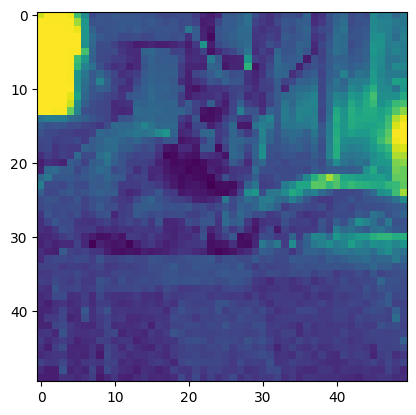

In [5]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0])
plt.show()

# this one might be better
# plt.imshow(training_data[1][0], cmap="gray")

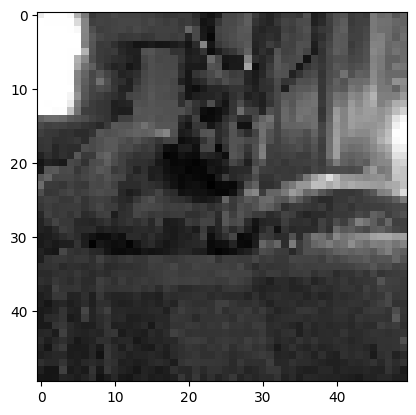

In [6]:
plt.imshow(training_data[1][0], cmap="gray")

#### Building the model...

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # build our networks
        
        self.conv1 = nn.Conv2d(1, 32, 5) # 2d convolutional layer
        # input, output, kernel size(window size)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        # after doing these we need to have a linear layer for output
        # but there is no documentation to do how
        # so we need to figure it out how

        # eg: for above issue
        # self.fc1 = nn.Linear(???, 512)
        # self.fc2 = nn.Linear(512, 2) # 2 -> classes/labels
        # what value to put to in place of ???

        # to figure this out we will have to pass a random data to it
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x) # to run forward the 3 conv layers

        # now doing this after finding the value of ???
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        # method to run forward the 3 conv layers
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        # to see the o/p
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x) # pass i through all the convolutional layers
        x = x.view(-1, self._to_linear) # flatten it
        x = F.relu(self.fc1(x)) # pass it through 1st fully connected layer
        x = self.fc2(x)
        # return x 
        
        # better with an activation function
        return F.softmax(x, dim=1)

net = Net()

torch.Size([128, 2, 2])


In [8]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
# reshaped the data
X = X/255.0
# scalinng the images
y = torch.Tensor([i[1] for i in training_data])

# splitting training/testing data
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

/tmp/ipykernel_17/954057395.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)


2494


In [9]:
train_X = X[: -val_size]
train_y = y[: -val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [10]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        # print(i, i+BATCH_SIZE)

        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()
        # can use optimizer.zero... 
        # depending on no of models or no of optimizers being used

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

print(loss)

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:10,  3.18it/s]

torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:00<01:03,  3.52it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:01,  3.60it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<00:58,  3.75it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:01<00:56,  3.89it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:01<00:55,  3.92it/s]

torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<00:56,  3.86it/s]

torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:02<00:56,  3.83it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:02<00:56,  3.81it/s]

torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:02<00:56,  3.81it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:03<00:54,  3.90it/s]

torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:03<00:54,  3.90it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:03<00:54,  3.86it/s]

torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:03<00:54,  3.84it/s]

torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:04<00:54,  3.86it/s]

torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:04<00:54,  3.82it/s]

torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:04<00:53,  3.85it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:05<00:53,  3.86it/s]

torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:05<00:53,  3.83it/s]

torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:05<00:53,  3.82it/s]

torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:05<00:53,  3.80it/s]

torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:06<00:53,  3.80it/s]

torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:06<00:52,  3.84it/s]

torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:06<00:51,  3.87it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:06<00:51,  3.90it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:07<00:50,  3.92it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:07<00:50,  3.88it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:07<00:50,  3.91it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:07<00:49,  3.93it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:08<00:49,  3.92it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:08<00:49,  3.93it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:08<00:48,  3.94it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:08<00:48,  3.95it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:09<00:48,  3.92it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:09<00:48,  3.93it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:09<00:47,  3.93it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:09<00:49,  3.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:10<00:57,  3.23it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:10<01:02,  2.97it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:11<01:06,  2.76it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:11<01:06,  2.73it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:12<01:00,  2.97it/s]

torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:12<00:56,  3.21it/s]

torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:12<00:53,  3.37it/s]

torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:12<00:50,  3.52it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:13<00:47,  3.72it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:13<00:46,  3.75it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:13<00:46,  3.77it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:13<00:45,  3.83it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:14<00:44,  3.87it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:14<00:44,  3.90it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:14<00:43,  3.92it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:14<00:43,  3.88it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:15<00:43,  3.87it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:15<00:42,  3.91it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:15<00:42,  3.96it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:16<00:42,  3.88it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:16<00:41,  3.94it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:16<00:41,  3.99it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:16<00:40,  4.00it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:17<00:40,  3.99it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:17<00:40,  3.98it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:17<00:40,  3.99it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:17<00:39,  3.99it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:18<00:39,  3.99it/s]

torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:18<00:39,  3.99it/s]

torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:18<00:39,  3.98it/s]

torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:18<00:38,  3.99it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:19<00:38,  3.97it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:19<00:39,  3.92it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:19<00:38,  3.91it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:19<00:38,  3.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:20<00:39,  3.80it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:20<00:38,  3.87it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:20<00:37,  3.91it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:21<00:37,  3.92it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:21<00:37,  3.90it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:21<00:37,  3.84it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:21<00:37,  3.84it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:22<00:36,  3.84it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:22<00:36,  3.86it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:22<00:35,  3.91it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:22<00:35,  3.94it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:23<00:34,  3.95it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:23<00:34,  3.99it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:23<00:33,  4.01it/s]

torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:23<00:32,  4.14it/s]

torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:24<00:32,  4.15it/s]

torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:24<00:32,  4.12it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:24<00:32,  4.10it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:24<00:32,  4.07it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:25<00:32,  4.04it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:25<00:31,  4.05it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:25<00:31,  4.01it/s]

torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:25<00:31,  4.02it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:26<00:31,  3.99it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:26<00:31,  4.00it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:26<00:30,  4.01it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:26<00:30,  4.01it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:27<00:30,  4.00it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:27<00:30,  4.00it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:27<00:30,  3.95it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:27<00:30,  3.89it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:28<00:30,  3.92it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:28<00:28,  4.04it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:28<00:28,  4.07it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:28<00:28,  4.06it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:29<00:28,  4.04it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:29<00:28,  4.03it/s]

torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:29<00:27,  4.02it/s]

torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:29<00:28,  3.92it/s]

torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:30<00:29,  3.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:30<00:31,  3.44it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:31<00:30,  3.54it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:31<00:28,  3.70it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:31<00:27,  3.78it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:31<00:27,  3.80it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:32<00:26,  3.82it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:32<00:26,  3.88it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:32<00:25,  3.92it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:32<00:25,  3.95it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:33<00:25,  3.95it/s]

torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:33<00:24,  3.93it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:33<00:24,  3.92it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:33<00:24,  3.96it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:34<00:23,  3.96it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:34<00:23,  3.96it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:34<00:23,  3.99it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:34<00:22,  4.05it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:35<00:22,  4.06it/s]

torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:35<00:22,  4.06it/s]

torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:35<00:21,  4.06it/s]

torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:35<00:21,  4.04it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:36<00:21,  4.03it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:36<00:21,  3.99it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:36<00:21,  4.01it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:36<00:20,  4.01it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:37<00:20,  4.01it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:37<00:20,  4.05it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:37<00:19,  4.05it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:37<00:19,  4.04it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:38<00:19,  4.00it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:38<00:19,  3.94it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:38<00:19,  3.91it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:38<00:19,  3.94it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:39<00:19,  3.93it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:39<00:18,  3.92it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:39<00:18,  3.94it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:39<00:17,  4.02it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:40<00:18,  3.86it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:40<00:18,  3.84it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:40<00:17,  3.87it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:40<00:17,  3.95it/s]

torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:41<00:17,  3.93it/s]

torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:41<00:16,  3.96it/s]

torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:41<00:16,  3.91it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:41<00:17,  3.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:42<00:18,  3.39it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:42<00:20,  2.99it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:43<00:22,  2.75it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:43<00:22,  2.63it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:43<00:23,  2.56it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [00:44<00:19,  2.89it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:44<00:17,  3.13it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:45<00:16,  3.33it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:45<00:15,  3.50it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [00:45<00:14,  3.62it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:45<00:13,  3.73it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:46<00:13,  3.79it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:46<00:12,  3.85it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [00:46<00:12,  3.88it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:46<00:12,  3.89it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:47<00:12,  3.90it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:47<00:11,  3.88it/s]

torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:47<00:11,  3.92it/s]

torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:47<00:11,  3.95it/s]

torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:48<00:10,  3.98it/s]

torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [00:48<00:10,  3.97it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:48<00:10,  3.98it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:48<00:09,  4.06it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [00:49<00:09,  3.98it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:49<00:09,  3.93it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:49<00:09,  3.96it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [00:49<00:09,  3.84it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [00:50<00:09,  3.77it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [00:50<00:08,  3.84it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [00:50<00:08,  3.88it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:50<00:08,  3.90it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [00:51<00:07,  3.92it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [00:51<00:07,  4.01it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [00:51<00:07,  4.06it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [00:51<00:06,  4.03it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [00:52<00:06,  3.98it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [00:52<00:06,  3.99it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [00:52<00:06,  4.09it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [00:52<00:05,  4.09it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [00:53<00:05,  4.00it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [00:53<00:05,  3.96it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [00:53<00:05,  3.97it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [00:53<00:05,  3.94it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [00:54<00:04,  3.94it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [00:54<00:04,  3.90it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [00:54<00:04,  3.87it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [00:55<00:04,  3.86it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [00:55<00:03,  3.90it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [00:55<00:03,  3.92it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [00:55<00:03,  3.89it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [00:56<00:03,  3.92it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [00:56<00:02,  4.06it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [00:56<00:02,  4.17it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [00:56<00:02,  4.25it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [00:56<00:01,  4.27it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [00:57<00:01,  4.17it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [00:57<00:01,  4.11it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [00:57<00:01,  4.07it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [00:57<00:00,  4.04it/s]

torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [00:58<00:00,  4.01it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [00:58<00:00,  4.01it/s]

torch.Size([128, 2, 2])


100%|█████████▉| 224/225 [00:58<00:00,  4.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:58<00:00,  3.82it/s]

tensor(0.2180, grad_fn=<MseLossBackward0>)


In [11]:
# prediction

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm (range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total, 3))

  4%|▍         | 105/2494 [00:00<00:04, 519.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  8%|▊         | 209/2494 [00:00<00:04, 506.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 11%|█         | 263/2494 [00:00<00:04, 515.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 15%|█▍        | 368/2494 [00:00<00:04, 473.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 19%|█▉        | 474/2494 [00:00<00:04, 498.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 23%|██▎       | 577/2494 [00:01<00:03, 496.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 27%|██▋       | 684/2494 [00:01<00:03, 514.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 32%|███▏      | 791/2494 [00:01<00:03, 522.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 36%|███▌      | 900/2494 [00:01<00:03, 530.31it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 40%|████      | 1009/2494 [00:01<00:02, 530.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 45%|████▍     | 1118/2494 [00:02<00:02, 536.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 49%|████▉     | 1227/2494 [00:02<00:02, 539.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 54%|█████▎    | 1335/2494 [00:02<00:02, 535.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 58%|█████▊    | 1443/2494 [00:02<00:01, 529.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 62%|██████▏   | 1550/2494 [00:02<00:01, 530.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 67%|██████▋   | 1659/2494 [00:03<00:01, 532.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 71%|███████   | 1767/2494 [00:03<00:01, 533.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 75%|███████▌  | 1875/2494 [00:03<00:01, 530.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 80%|███████▉  | 1983/2494 [00:03<00:00, 531.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 84%|████████▍ | 2092/2494 [00:04<00:00, 536.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 88%|████████▊ | 2201/2494 [00:04<00:00, 532.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 93%|█████████▎| 2309/2494 [00:04<00:00, 521.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 97%|█████████▋| 2417/2494 [00:04<00:00, 528.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2494/2494 [00:04<00:00, 521.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

#### basic model analysis

In [12]:
# testing

def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)

    # calculating accuracy
    matches = [torch.argmax(i) == torch.argmax(j) for i,j, in zip(outputs,y)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    
    return acc, loss

In [13]:
def test(size=32):
    random_start = np.random.randint(len(test_X) - size)
    X, y, = test_X[random_start : random_start + size], test_y[random_start : random_start + size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50), y)
    return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

torch.Size([128, 2, 2])
0.625 tensor(0.1967)


In [14]:
import time

MODEL_NAME = f"model-{int(time.time())}"

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 100
    EPOCHS = 5
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
                batch_y = train_y[i:i+BATCH_SIZE]

                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

train()

torch.Size([128, 2, 2])
model-1726908369


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  0%|          | 1/225 [00:00<01:23,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:22,  2.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:01<01:21,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:18,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<01:19,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:02<01:18,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:02<01:18,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<01:17,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:03<01:18,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:03<01:20,  2.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:04<01:19,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:04<01:17,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:04<01:16,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:05<01:16,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:05<01:15,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:05<01:14,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:06<01:14,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:06<01:13,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:06<01:13,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:07<01:13,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:07<01:12,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:07<01:15,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:08<01:25,  2.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:09<01:33,  2.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:09<01:37,  2.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:10<01:41,  1.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:10<01:33,  2.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:10<01:26,  2.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:11<01:21,  2.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:11<01:17,  2.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:12<01:14,  2.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:12<01:12,  2.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:12<01:10,  2.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:13<01:10,  2.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:13<01:10,  2.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:13<01:10,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:14<01:09,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:14<01:08,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:14<01:06,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:15<01:06,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:15<01:05,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:15<01:05,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:16<01:05,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:16<01:05,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:17<01:03,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:17<01:02,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:17<01:01,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:18<01:03,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:18<01:03,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:18<01:02,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:19<01:02,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:19<01:01,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:19<01:01,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:20<01:01,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:20<00:59,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:20<00:59,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:21<00:59,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:21<00:59,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:22<00:58,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:22<00:58,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:22<00:57,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:23<00:57,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:23<00:59,  2.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:23<00:59,  2.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:24<00:58,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:24<00:57,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:24<00:56,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:25<00:56,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:25<00:55,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:25<00:55,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:26<00:54,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:26<00:54,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:27<00:54,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:27<00:54,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:27<00:52,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:28<00:53,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:28<00:52,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:28<00:52,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:29<00:51,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:29<00:51,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:29<00:50,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:30<00:54,  2.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:30<00:55,  2.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:31<00:53,  2.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:31<00:52,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:31<00:50,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:32<00:50,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:32<00:48,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:32<00:48,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:33<00:48,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:33<00:49,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:33<00:47,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:34<00:47,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:34<00:46,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:35<00:46,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:35<00:45,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:35<00:45,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:36<00:44,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:36<00:44,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:36<00:43,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:37<00:43,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:37<00:43,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:37<00:43,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:38<00:43,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:38<00:42,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:38<00:42,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:39<00:41,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:39<00:41,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:39<00:41,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:40<00:40,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:40<00:45,  2.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:41<00:48,  2.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:41<00:52,  2.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:42<00:55,  2.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:42<00:54,  2.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:43<00:49,  2.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:43<00:47,  2.28it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:44<00:44,  2.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:44<00:42,  2.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:44<00:39,  2.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:45<00:38,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:45<00:37,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:45<00:36,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:46<00:36,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:46<00:35,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:46<00:34,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:47<00:34,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:47<00:33,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:47<00:33,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:48<00:33,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:48<00:33,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:48<00:31,  2.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:49<00:31,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:49<00:31,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:49<00:31,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:50<00:30,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:50<00:30,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:51<00:30,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:51<00:30,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:51<00:29,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:52<00:29,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:52<00:29,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:52<00:28,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:53<00:28,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:53<00:29,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:53<00:28,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:54<00:27,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:54<00:27,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:54<00:26,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:55<00:26,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:55<00:26,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:55<00:25,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:56<00:25,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:56<00:24,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:57<00:24,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:57<00:24,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:57<00:23,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:58<00:23,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:58<00:23,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:58<00:22,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:59<00:22,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:59<00:22,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:59<00:21,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [01:00<00:21,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [01:00<00:21,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [01:00<00:22,  2.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [01:01<00:22,  2.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [01:01<00:21,  2.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [01:02<00:20,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [01:02<00:19,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [01:02<00:19,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [01:03<00:18,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [01:03<00:19,  2.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [01:03<00:18,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [01:04<00:18,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [01:04<00:17,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [01:04<00:17,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [01:05<00:16,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [01:05<00:16,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 180/225 [01:05<00:15,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 181/225 [01:06<00:15,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████  | 182/225 [01:06<00:15,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [01:07<00:14,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [01:07<00:14,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [01:07<00:14,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [01:08<00:13,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [01:08<00:13,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [01:08<00:12,  2.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [01:09<00:12,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [01:09<00:12,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [01:09<00:11,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [01:10<00:11,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [01:10<00:11,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [01:10<00:11,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [01:11<00:10,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [01:11<00:10,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [01:11<00:09,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [01:12<00:09,  2.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [01:12<00:09,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [01:12<00:08,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [01:13<00:09,  2.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:14<00:10,  2.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [01:14<00:10,  2.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:15<00:10,  1.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [01:15<00:09,  2.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:15<00:08,  2.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:16<00:07,  2.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:16<00:06,  2.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:16<00:06,  2.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:17<00:05,  2.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:17<00:05,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [01:18<00:04,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [01:18<00:04,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:18<00:03,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [01:19<00:03,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [01:19<00:03,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:19<00:02,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:20<00:02,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:20<00:02,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [01:20<00:01,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:21<00:01,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:21<00:01,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [01:21<00:00,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|█████████▉| 224/225 [01:22<00:00,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [01:22<00:00,  2.73it/s]


torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  0%|          | 1/225 [00:00<01:23,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:22,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:01<01:25,  2.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:22,  2.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<01:20,  2.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:02<01:18,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:02<01:17,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<01:16,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:03<01:16,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:03<01:16,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:03<01:15,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:04<01:15,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:04<01:14,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:05<01:13,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:05<01:13,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:05<01:12,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:06<01:13,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:06<01:13,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:06<01:12,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:07<01:11,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:07<01:11,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:07<01:11,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:08<01:11,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:08<01:09,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:08<01:17,  2.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:09<01:16,  2.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:09<01:14,  2.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:10<01:12,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:10<01:11,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:10<01:11,  2.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:11<01:13,  2.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:11<01:10,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:11<01:09,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:12<01:08,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:12<01:07,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:12<01:06,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:13<01:06,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:13<01:05,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:13<01:05,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:14<01:05,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:14<01:04,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:15<01:03,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:15<01:03,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:15<01:02,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:16<01:02,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:16<01:03,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:16<01:03,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:17<01:02,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:17<01:01,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:17<01:00,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:18<01:00,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:18<01:00,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:18<01:00,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:19<01:00,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:19<01:00,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:19<00:58,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:20<00:59,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:20<00:59,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:21<01:00,  2.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:21<00:58,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:21<00:56,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:22<00:57,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:22<00:57,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:22<00:57,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:23<01:01,  2.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:23<01:08,  2.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:24<01:13,  2.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:24<01:17,  2.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:25<01:19,  1.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:25<01:11,  2.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:26<01:05,  2.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:26<01:01,  2.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:26<00:58,  2.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:27<00:57,  2.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:27<00:55,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:27<00:54,  2.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:28<00:52,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:28<00:52,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:28<00:51,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:29<00:51,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:29<00:50,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:29<00:50,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:30<00:49,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:30<00:49,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:31<00:50,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:31<00:49,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:31<00:48,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:32<00:48,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:32<00:47,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:32<00:47,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:33<00:46,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:33<00:46,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:33<00:46,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:34<00:46,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:34<00:45,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:34<00:45,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:35<00:45,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:35<00:44,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:35<00:43,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:36<00:43,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:36<00:43,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:37<00:43,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:37<00:43,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:37<00:42,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:38<00:42,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:38<00:42,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:38<00:41,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:39<00:41,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:39<00:47,  2.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:40<00:44,  2.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:40<00:43,  2.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:40<00:41,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:41<00:42,  2.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:41<00:41,  2.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:41<00:40,  2.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:42<00:38,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:42<00:38,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:42<00:37,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:43<00:37,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:43<00:37,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:43<00:36,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:44<00:35,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:44<00:35,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:44<00:34,  2.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:45<00:34,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:45<00:34,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:46<00:34,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:46<00:33,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:46<00:33,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:47<00:33,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:47<00:33,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:47<00:32,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:48<00:32,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:48<00:32,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:48<00:31,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:49<00:30,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:49<00:30,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:49<00:30,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:50<00:30,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:50<00:29,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:50<00:29,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:51<00:29,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:51<00:29,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:51<00:28,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:52<00:28,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:52<00:28,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:53<00:27,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:53<00:26,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:53<00:26,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:54<00:26,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:54<00:25,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:54<00:25,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:55<00:25,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:55<00:24,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:56<00:29,  2.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:56<00:32,  2.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:57<00:33,  2.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:57<00:30,  2.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:57<00:27,  2.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:58<00:25,  2.52it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:58<00:24,  2.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:58<00:23,  2.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:59<00:22,  2.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:59<00:22,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [01:00<00:21,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [01:00<00:21,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [01:00<00:20,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [01:01<00:20,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [01:01<00:19,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [01:01<00:19,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [01:02<00:19,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [01:02<00:18,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [01:02<00:18,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [01:03<00:17,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [01:03<00:17,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [01:03<00:16,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [01:04<00:16,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [01:04<00:16,  2.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [01:04<00:15,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 180/225 [01:05<00:15,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 181/225 [01:05<00:15,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████  | 182/225 [01:05<00:14,  2.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [01:06<00:14,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [01:06<00:13,  2.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [01:06<00:13,  2.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [01:07<00:13,  2.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [01:07<00:13,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [01:07<00:12,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [01:08<00:12,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [01:08<00:12,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [01:09<00:11,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [01:09<00:11,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [01:09<00:12,  2.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [01:10<00:12,  2.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [01:10<00:11,  2.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [01:11<00:11,  2.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [01:11<00:10,  2.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [01:11<00:09,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [01:12<00:09,  2.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [01:12<00:09,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [01:12<00:08,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:13<00:07,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [01:13<00:07,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:13<00:07,  2.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [01:14<00:06,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:14<00:06,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:14<00:06,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:15<00:05,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:15<00:05,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:15<00:05,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:16<00:04,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [01:16<00:04,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [01:17<00:04,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:17<00:03,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [01:17<00:03,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [01:18<00:03,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:18<00:02,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:18<00:02,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:19<00:02,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [01:19<00:01,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:19<00:01,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:20<00:01,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [01:20<00:00,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|█████████▉| 224/225 [01:20<00:00,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [01:21<00:00,  2.77it/s]


torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  0%|          | 1/225 [00:00<01:19,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:17,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:01<01:18,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:18,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<01:18,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:02<01:18,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:02<01:17,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<01:17,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:03<01:15,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:03<01:15,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:03<01:14,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:04<01:14,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:04<01:14,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:04<01:13,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:05<01:12,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:05<01:12,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:05<01:12,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:06<01:16,  2.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:06<01:25,  2.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:07<01:34,  2.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:08<01:42,  1.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:08<01:33,  2.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:08<01:25,  2.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:09<01:21,  2.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:09<01:17,  2.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:09<01:18,  2.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:10<01:15,  2.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:10<01:13,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:10<01:11,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:11<01:10,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:11<01:09,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:12<01:09,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:12<01:07,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:12<01:07,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:13<01:06,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:13<01:06,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:13<01:06,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:14<01:06,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:14<01:04,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:14<01:04,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:15<01:04,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:15<01:04,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:15<01:03,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:16<01:03,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:16<01:01,  2.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:16<01:02,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:17<01:01,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:17<01:01,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:17<01:01,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:18<01:01,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:18<00:59,  2.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:18<01:00,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:19<01:03,  2.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:19<01:12,  2.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:20<01:08,  2.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:20<01:05,  2.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:20<01:02,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:21<01:01,  2.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:21<01:00,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:22<00:58,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:22<00:57,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:22<00:57,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:23<00:56,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:23<00:55,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:23<00:55,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:24<00:55,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:24<00:55,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:24<00:55,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:25<00:55,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:25<00:53,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:25<00:53,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:26<00:53,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:26<00:53,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:26<00:53,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:27<00:53,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:27<00:52,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:27<00:52,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:28<00:51,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:28<00:51,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:29<00:51,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:29<00:50,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:29<00:49,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:30<00:51,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:30<00:50,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:30<00:50,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:31<00:48,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:31<00:48,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:31<00:47,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:32<00:47,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:32<00:47,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:32<00:46,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:33<00:46,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:33<00:46,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:33<00:45,  2.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:34<00:45,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:34<00:44,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:34<00:44,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:35<00:43,  2.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:35<00:43,  2.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:35<00:42,  2.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:36<00:42,  2.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:36<00:41,  2.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:37<00:42,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:37<00:42,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:37<00:41,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:38<00:41,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:38<00:47,  2.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:39<00:52,  2.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:39<00:57,  2.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:40<00:54,  2.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:40<00:49,  2.29it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:40<00:45,  2.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:41<00:43,  2.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:41<00:41,  2.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:41<00:40,  2.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:42<00:39,  2.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:42<00:38,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:42<00:37,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:43<00:37,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:43<00:36,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:44<00:36,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:44<00:35,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:44<00:35,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:45<00:34,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:45<00:34,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:45<00:34,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:46<00:34,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:46<00:33,  2.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:46<00:33,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:47<00:32,  2.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:47<00:32,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:47<00:32,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:48<00:31,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:48<00:31,  2.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:48<00:31,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:49<00:30,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:49<00:30,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:49<00:31,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:50<00:36,  2.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:50<00:34,  2.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:51<00:32,  2.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:51<00:31,  2.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:51<00:30,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:52<00:29,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:52<00:29,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:52<00:28,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:53<00:27,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:53<00:27,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:54<00:26,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:54<00:26,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:54<00:26,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:55<00:25,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:55<00:25,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:55<00:24,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:56<00:24,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:56<00:23,  2.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:56<00:23,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:57<00:22,  2.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:57<00:22,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:57<00:22,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:58<00:22,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:58<00:21,  2.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:58<00:21,  2.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:59<00:20,  2.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:59<00:20,  2.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:59<00:20,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [01:00<00:20,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [01:00<00:20,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [01:00<00:19,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [01:01<00:19,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [01:01<00:18,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [01:02<00:18,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [01:02<00:18,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [01:02<00:17,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [01:03<00:17,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [01:03<00:17,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [01:03<00:17,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [01:04<00:16,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [01:04<00:16,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 180/225 [01:04<00:15,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 181/225 [01:05<00:15,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████  | 182/225 [01:05<00:14,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [01:05<00:14,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [01:06<00:14,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [01:06<00:13,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [01:06<00:13,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [01:07<00:13,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [01:07<00:12,  2.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [01:07<00:12,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [01:08<00:12,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [01:08<00:11,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [01:09<00:11,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [01:09<00:11,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [01:09<00:10,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [01:10<00:11,  2.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [01:10<00:12,  2.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [01:11<00:13,  2.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [01:11<00:13,  2.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [01:12<00:12,  2.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [01:12<00:11,  2.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [01:13<00:10,  2.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:13<00:09,  2.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [01:13<00:08,  2.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:14<00:07,  2.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [01:14<00:07,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:14<00:06,  2.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:15<00:06,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:15<00:06,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:15<00:05,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:16<00:05,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:16<00:04,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [01:16<00:04,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [01:17<00:04,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:17<00:03,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [01:17<00:03,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [01:18<00:03,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:18<00:02,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:18<00:02,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:19<00:02,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [01:19<00:01,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:20<00:01,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:20<00:01,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [01:20<00:00,  2.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|█████████▉| 224/225 [01:21<00:00,  2.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [01:21<00:00,  2.76it/s]


torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  0%|          | 1/225 [00:00<01:20,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:19,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:01<01:18,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:16,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<01:17,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:02<01:17,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:02<01:16,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<01:14,  2.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:03<01:14,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:03<01:13,  2.92it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:03<01:14,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:04<01:13,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:04<01:14,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:04<01:14,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:05<01:13,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:05<01:12,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:05<01:12,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:06<01:12,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:06<01:12,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:07<01:12,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:07<01:12,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:07<01:11,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:08<01:12,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:08<01:14,  2.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:08<01:13,  2.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:09<01:10,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:09<01:10,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:09<01:10,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:10<01:09,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:10<01:08,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:10<01:08,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:11<01:07,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:11<01:07,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:11<01:07,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:12<01:06,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:12<01:06,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:13<01:06,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:13<01:05,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:13<01:05,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:14<01:04,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:14<01:03,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:14<01:04,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:15<01:03,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:15<01:03,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:15<01:03,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:16<01:02,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:16<01:02,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:16<01:02,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:17<01:02,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:17<01:00,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:17<01:01,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:18<01:02,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:18<01:01,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:19<01:01,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:19<01:00,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:19<00:59,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:20<00:59,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:20<00:57,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:20<01:04,  2.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:21<01:09,  2.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:21<01:16,  2.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:22<01:21,  2.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:22<01:14,  2.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:23<01:09,  2.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:23<01:04,  2.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:23<01:01,  2.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:24<00:59,  2.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:24<00:58,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:25<00:55,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:25<00:55,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:25<00:54,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:26<00:54,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:26<00:54,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:26<00:53,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:27<00:53,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:27<00:53,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:27<00:51,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:28<00:52,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:28<00:53,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:28<00:52,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:29<00:51,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:29<00:50,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:30<00:55,  2.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:30<00:57,  2.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:30<00:54,  2.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:31<00:51,  2.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:31<00:51,  2.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:31<00:50,  2.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:32<00:48,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:32<00:48,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:32<00:47,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:33<00:47,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:33<00:46,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:34<00:46,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:34<00:46,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:34<00:45,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:35<00:44,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:35<00:44,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:35<00:44,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:36<00:44,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:36<00:43,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:36<00:43,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:37<00:42,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:37<00:42,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:37<00:42,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:38<00:42,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:38<00:42,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:39<00:41,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:39<00:41,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:39<00:40,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:40<00:40,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:40<00:39,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:40<00:39,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:41<00:39,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:41<00:38,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:41<00:37,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:42<00:37,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:42<00:37,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:42<00:37,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:43<00:36,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:43<00:36,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:43<00:36,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:44<00:36,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:44<00:35,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:44<00:35,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:45<00:34,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:45<00:34,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:46<00:33,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:46<00:33,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:46<00:32,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:47<00:32,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:47<00:32,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:47<00:32,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:48<00:31,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:48<00:32,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:48<00:31,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:49<00:31,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:49<00:31,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:49<00:30,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:50<00:29,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:50<00:29,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:50<00:28,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:51<00:28,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:51<00:28,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:52<00:28,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:52<00:27,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:52<00:28,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:53<00:31,  2.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:53<00:34,  2.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:54<00:36,  2.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:54<00:37,  1.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:55<00:33,  2.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:55<00:30,  2.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:56<00:28,  2.49it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:56<00:27,  2.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:56<00:26,  2.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:57<00:25,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:57<00:23,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:57<00:23,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:58<00:22,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:58<00:23,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:58<00:22,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:59<00:22,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:59<00:21,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:59<00:21,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [01:00<00:20,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [01:00<00:22,  2.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [01:01<00:23,  2.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [01:01<00:22,  2.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [01:01<00:20,  2.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [01:02<00:20,  2.67it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [01:02<00:19,  2.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [01:02<00:19,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [01:03<00:18,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [01:03<00:17,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [01:03<00:17,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [01:04<00:17,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [01:04<00:16,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [01:05<00:16,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 180/225 [01:05<00:16,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 181/225 [01:05<00:15,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████  | 182/225 [01:06<00:15,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [01:06<00:14,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [01:06<00:14,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [01:07<00:14,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [01:07<00:13,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [01:07<00:13,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [01:08<00:13,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [01:08<00:12,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [01:08<00:12,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [01:09<00:12,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [01:09<00:11,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [01:10<00:11,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [01:10<00:10,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [01:10<00:10,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [01:11<00:10,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [01:11<00:09,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [01:11<00:09,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [01:12<00:09,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [01:12<00:08,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [01:12<00:08,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:13<00:08,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [01:13<00:07,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:13<00:07,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [01:14<00:07,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:14<00:06,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:14<00:06,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:15<00:05,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:15<00:05,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:15<00:05,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:16<00:04,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [01:16<00:04,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [01:16<00:04,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:17<00:03,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [01:17<00:03,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [01:18<00:03,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:18<00:02,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:18<00:02,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:19<00:02,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [01:19<00:01,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:19<00:01,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:20<00:01,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [01:20<00:00,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|█████████▉| 224/225 [01:20<00:00,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [01:21<00:00,  2.77it/s]


torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  0%|          | 1/225 [00:00<01:19,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:18,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:01<01:18,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:16,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<01:16,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:02<01:15,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:02<01:16,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<01:15,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:03<01:15,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:03<01:15,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:03<01:16,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:04<01:25,  2.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:04<01:35,  2.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:05<01:44,  2.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:05<01:38,  2.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:06<01:29,  2.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:06<01:24,  2.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:07<01:22,  2.52it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:07<01:21,  2.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:07<01:17,  2.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:08<01:15,  2.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:08<01:14,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:08<01:12,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:09<01:11,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:09<01:11,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:09<01:09,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:10<01:16,  2.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:10<01:20,  2.46it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:11<01:17,  2.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:11<01:12,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:11<01:10,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:12<01:09,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:12<01:08,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:12<01:08,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:13<01:06,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:13<01:07,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:13<01:06,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:14<01:06,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:14<01:05,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:14<01:05,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:15<01:05,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:15<01:05,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:16<01:05,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:16<01:04,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:16<01:03,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:17<01:05,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:17<01:03,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:17<01:03,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:18<01:02,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:18<01:02,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:18<01:01,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:19<01:01,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:19<01:00,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:19<01:00,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:20<00:59,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:20<00:59,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:20<00:59,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:21<00:59,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:21<00:57,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:22<00:58,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:22<00:57,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:22<00:57,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:23<00:57,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:23<00:56,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:23<00:55,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:24<00:55,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:24<00:55,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:24<00:55,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:25<00:55,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:25<00:54,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:25<00:53,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:26<00:53,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:26<00:53,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:26<00:53,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:27<00:54,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:27<00:53,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:28<00:53,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:28<00:52,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:28<00:52,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:29<00:51,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:29<00:50,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:29<00:50,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:30<00:50,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:30<00:50,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:30<00:48,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:31<00:48,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:31<00:48,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:31<00:48,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:32<00:48,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:32<00:47,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:32<00:46,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:33<00:46,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:33<00:45,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:34<00:45,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:34<00:45,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:34<00:45,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:35<00:44,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:35<00:44,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:35<00:44,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:36<00:52,  2.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:36<00:58,  2.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:37<01:01,  2.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:37<00:54,  2.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:38<00:51,  2.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:38<00:48,  2.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:38<00:46,  2.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:39<00:44,  2.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:39<00:43,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:39<00:42,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:40<00:41,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:40<00:44,  2.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:41<00:46,  2.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:41<00:44,  2.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:41<00:42,  2.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:42<00:40,  2.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:42<00:40,  2.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:43<00:39,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:43<00:38,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:43<00:38,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:44<00:37,  2.78it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:44<00:36,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:44<00:36,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:45<00:35,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:45<00:36,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:45<00:35,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:46<00:35,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:46<00:34,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:46<00:34,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:47<00:35,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:47<00:34,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:48<00:34,  2.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:48<00:33,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:48<00:32,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:49<00:32,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:49<00:31,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:49<00:31,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:50<00:30,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:50<00:30,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:50<00:29,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:51<00:29,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:51<00:29,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:51<00:29,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:52<00:28,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:52<00:28,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:52<00:27,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:53<00:27,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:53<00:27,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:53<00:26,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:54<00:27,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:54<00:26,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:55<00:25,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:55<00:25,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:55<00:24,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:56<00:24,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:56<00:24,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:56<00:24,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:57<00:24,  2.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:57<00:23,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:57<00:23,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:58<00:23,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:58<00:22,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:58<00:22,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:59<00:21,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:59<00:21,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:59<00:20,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [01:00<00:20,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [01:00<00:20,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [01:01<00:19,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [01:01<00:19,  2.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [01:01<00:19,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [01:02<00:18,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [01:02<00:18,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [01:02<00:18,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [01:03<00:17,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [01:03<00:17,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [01:03<00:17,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [01:04<00:16,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [01:04<00:16,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [01:04<00:16,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 180/225 [01:05<00:15,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 181/225 [01:05<00:15,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████  | 182/225 [01:05<00:14,  2.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [01:06<00:14,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [01:06<00:14,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [01:07<00:14,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [01:07<00:14,  2.68it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [01:07<00:15,  2.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [01:08<00:16,  2.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [01:09<00:17,  2.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [01:09<00:17,  2.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [01:09<00:15,  2.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [01:10<00:14,  2.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [01:10<00:12,  2.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [01:10<00:12,  2.56it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [01:11<00:12,  2.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [01:11<00:13,  2.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [01:12<00:11,  2.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [01:12<00:10,  2.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [01:13<00:10,  2.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [01:13<00:09,  2.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [01:13<00:08,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:14<00:08,  2.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [01:14<00:07,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:14<00:07,  2.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [01:15<00:07,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:15<00:06,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:15<00:06,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:16<00:05,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:16<00:05,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:16<00:05,  2.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:17<00:05,  2.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [01:17<00:04,  2.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [01:17<00:04,  2.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:18<00:03,  2.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [01:18<00:03,  2.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [01:19<00:03,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:19<00:02,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:19<00:02,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:20<00:02,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [01:20<00:01,  2.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:20<00:01,  2.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:21<00:01,  2.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [01:21<00:00,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|█████████▉| 224/225 [01:21<00:00,  2.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [01:22<00:00,  2.74it/s]

torch.Size([128, 2, 2])


/tmp/ipykernel_17/1214788099.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2,1), (0,0), sharex=ax1)


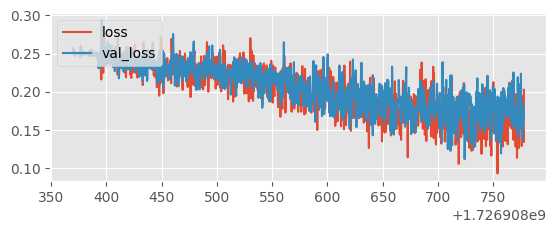

In [15]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = MODEL_NAME    # (model name from above)

def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split('\n')

    times = []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
            
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (0,0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)

    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)

    plt.show()

create_acc_loss_graph(model_name)